<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'signal, arb.units')

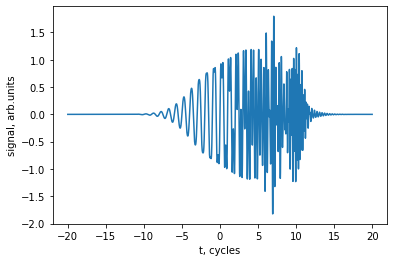

In [ ]:
# generate the signal
nofts=1000
t=np.linspace(-20*2*pi, 20*2*pi, 2**14+5)
t=np.linspace(-20*2*pi, 20*2*pi, 3**9+6)
y=np.sin(t)*exp(-t**2/2/20**2)
y=y+np.sin(3*t)*exp(-(t-5*2*pi)**2/2/20**2)
y=y+np.sin(5.5*t)*exp(-(t-10*2*pi)**2/2/5**2)
y=y+np.sin(4*t)*exp(-(t-7*2*pi)**2/2/5**2)

plt.plot(t/2/pi,y)

xlabel('t, cycles')
ylabel('signal, arb.units')

Text(0, 0.5, 'Power spectrum, arb. units')

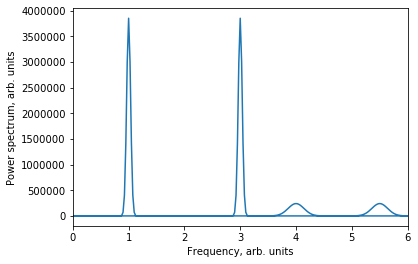

In [ ]:
# Fourier spectrum
sp=fft.fft(y)
w=fft.fftfreq(len(y), d=(t[1]-t[0])/2/pi)
plot(w, abs(sp)**2)
xlim(0,6)
xlabel('Frequency, arb. units')
ylabel('Power spectrum, arb. units')

(0, 10)

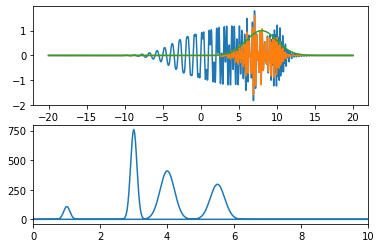

In [ ]:
# windowed Fourier transform (Gabor transform, spectrogram)

window_width=2.0*2*pi
window_position=8*2*pi
window_function=exp(-(t-window_position)**2/2/window_width**2)

y_window=y * window_function

subplot(211)
plot(t/2/pi, y)
plot(t/2/pi, y_window)
plot(t/2/pi, window_function)

sp = fft.fft(y_window)
w=fft.fftfreq(len(y), d=(t[1]-t[0])/2/pi)
subplot(212)
plot(w, abs(sp))
xlim(0, 10)
# now do the same for different window positions and plot 2D graph
# x_axis is window position
# y_axis is frequency
# color axis represents the power spectrum

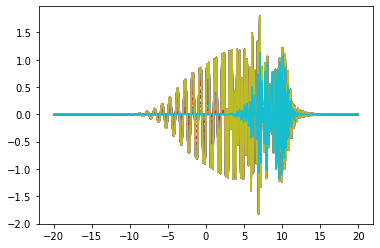

In [ ]:
for i in range(-10,10,1):
  window_width=2.0*2*pi
  window_position=i*2*pi
  window_function=exp(-(t-window_position)**2/2/window_width**2)

  y_window=y * window_function

  plot(t/2/pi, y)
  plot(t/2/pi, y_window)

# Implement parallel computation of the spectrogram

In [ ]:
%%writefile task_6_test.py
#try to parralell
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from random import random

comm = MPI.COMM_WORLD #create a communicator
rank = comm.Get_rank() #rank of executing process
size = comm.Get_size() #gives number of ranks in comm
#print("my rank is ", rank)

nofts=1000
t=np.linspace(-20*2*np.pi, 20*2*np.pi, 2**14+5)
t=np.linspace(-20*2*np.pi, 20*2*np.pi, 3**9+6)
y=np.sin(t)*np.exp(-t**2/2/20**2)
y=y+np.sin(3*t)*np.exp(-(t-5*2*np.pi)**2/2/20**2)
y=y+np.sin(5.5*t)*np.exp(-(t-10*2*np.pi)**2/2/5**2)
y=y+np.sin(4*t)*np.exp(-(t-7*2*np.pi)**2/2/5**2)


nwindowsteps = 1500

t_window = np.linspace(-20*2*np.pi, 20*2*np.pi, nwindowsteps)
tw_list = np.array_split(t_window,size)[rank]
numDataPerRank = int((t_window.size)/size)

window_width=2.0*2*np.pi
specgram = np.empty([len(t), len(t_window)])

for n, t_w in enumerate(tw_list):
  window_position = t_w
  window_function = np.exp(-(t-window_position)**2/2/window_width**2)
  y_window = y * window_function
  #plot(y_window)
  specgram[:,n] = abs(np.fft.fft(y_window))
      
#comm.Gather(sendbuf, recvbuf, root=0)
recieved_x = comm.gather(specgram,root=0) 

if rank == 0:
    recv_x = np.hstack(specgram) 
    #plt.imshow(specgram) #, aspect='auto', origin='lower', extent=[min(t)/2/pi, max(t)/2/pi, w[0], 2*w[int(len(w)/2/100)]])
    #plt.colorbar()
    #plt.ylim(0, 300)

Overwriting task_6_test.py


In [ ]:
! mpirun --allow-run-as-root -n 1 python3 task_6_test.py

# Plot speedup vs number of processes

In [ ]:
time_arr = []
for i in range(1, 7):
    print(f'{i} process(es)\n\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_6_test.py
    time_arr.append(t.best)

1 process(es)
	8.15 s ± 22.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 process(es)
	5.64 s ± 616 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3 process(es)
	4.38 s ± 39.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4 process(es)
	4.18 s ± 93.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
5 process(es)
	4.1 s ± 59.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6 process(es)
	4.14 s ± 25.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Text(0.5, 0.98, 'Speedup vs Np')

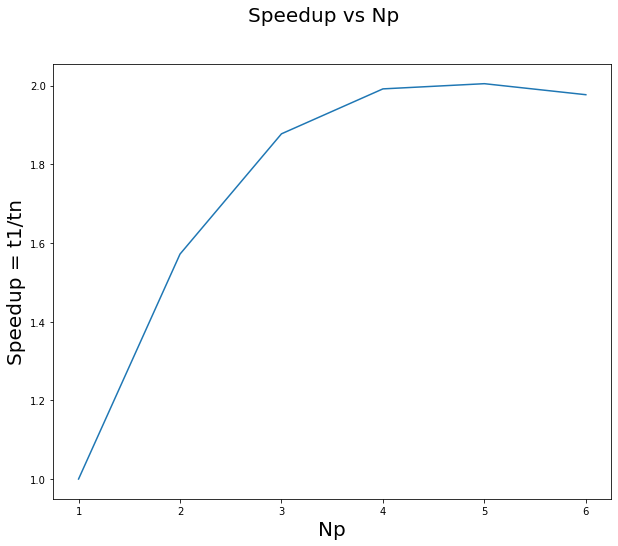

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

speedup = time_arr[0] / np.array(time_arr)
num_of_processes = range(1, 7)

plt.figure(figsize=(10, 8))
plt.plot(num_of_processes, speedup)
plt.xticks(num_of_processes)
plt.xlabel('Np', fontsize = 20)
plt.ylabel('Speedup = t1/tn', fontsize = 20)
plt.suptitle('Speedup vs Np', fontsize = 20)